In [1]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from typing import List

from client.generator import ImageDataGenerator
from neural_network.layers.base_layer import BaseLayer
from neural_network.layers.linear_layer import LinearLayer
from neural_network.layers.relu_layer import ReluLayer
from neural_network.layers.sigmoid_layer import SigmoidLayer
from neural_network.models.layer_types import LayerTypes
from neural_network.utils import predict

from neural_network.losses.squared_loss import SquaredLoss

2023-12-15 17:19:27.433002: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 17:19:27.914511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 17:19:27.914606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 17:19:27.944297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 17:19:28.014717: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 17:19:28.016098: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
TRAIN_TF_MODEL = True

MODEL_PATH = "image-embedder/working.h5"
DATASET_PATH = "./images-data1/"
TEST_DATASET_PATH = "./images-data1-test/"
MASK_PATH = "./images-data1-mask/mask-1.mat"

EMBEDDING_FEATURE_DIM = 100

EPOCHS = 20
BATCH_SIZE = 2
LEARNING_RATE = 1e-3

In [3]:
train_data = ImageDataGenerator(
    dataset_path=DATASET_PATH, model_path=MODEL_PATH, mask_path=MASK_PATH, use_dynamic_mask=True
)
test_data = ImageDataGenerator(
    dataset_path=TEST_DATASET_PATH, model_path=MODEL_PATH, mask_path=MASK_PATH, use_dynamic_mask=True
)

In [4]:
N_TRAIN = len(train_data)
N_TEST = len(test_data)

In [5]:
train_ds = (
    tf.data.Dataset.from_generator(
        train_data,
        output_types=(tf.float32, tf.float32),
        output_shapes=(
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        ),
    )
    .shuffle(1000)
    .batch(BATCH_SIZE)
)


test_ds = tf.data.Dataset.from_generator(
    test_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=(
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
    ),
).batch(1)

In [6]:
if TRAIN_TF_MODEL:
    tf_neural_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(EMBEDDING_FEATURE_DIM)),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(2, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(EMBEDDING_FEATURE_DIM),
        ]
    )

    tf_neural_net.compile(loss="mse", optimizer="adam", metrics="mse")

In [7]:
# neural network: nothing but a list of layers!
neural_net: List[BaseLayer] = [
    LinearLayer(input_size=EMBEDDING_FEATURE_DIM, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=2),
    ReluLayer(),
    LinearLayer(input_size=2, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=EMBEDDING_FEATURE_DIM),
    SigmoidLayer(),
]

loss = SquaredLoss()

In [8]:
if TRAIN_TF_MODEL:
    history = tf_neural_net.fit(train_ds, epochs=EPOCHS)

Epoch 1/20


57/57 [==============================] - 2s 2ms/step - loss: 1.4428e-04 - mse: 1.4428e-04
Epoch 2/20
57/57 [==============================] - 2s 1ms/step - loss: 5.0781e-05 - mse: 5.0781e-05
Epoch 3/20
57/57 [==============================] - 2s 1ms/step - loss: 5.1324e-05 - mse: 5.1324e-05
Epoch 4/20
57/57 [==============================] - 2s 1ms/step - loss: 5.1013e-05 - mse: 5.1013e-05
Epoch 5/20
57/57 [==============================] - 2s 1ms/step - loss: 5.1113e-05 - mse: 5.1113e-05
Epoch 6/20
57/57 [==============================] - 1s 1ms/step - loss: 5.1255e-05 - mse: 5.1255e-05
Epoch 7/20
57/57 [==============================] - 2s 1ms/step - loss: 5.1641e-05 - mse: 5.1641e-05
Epoch 8/20
57/57 [==============================] - 1s 1ms/step - loss: 5.1053e-05 - mse: 5.1053e-05
Epoch 9/20
57/57 [==============================] - 1s 1ms/step - loss: 5.0059e-05 - mse: 5.0059e-05
Epoch 10/20
57/57 [==============================] - 1s 1ms/step - loss: 5.1117e-05 - mse: 5.1117e-05


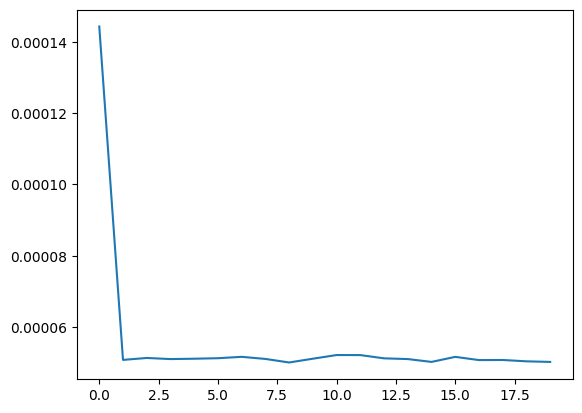

In [9]:
if TRAIN_TF_MODEL:
    plt.figure()
    plt.plot(history.history["loss"])

In [10]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = []
    for ix, (x_batch, y_batch) in enumerate(train_ds):
        X_batch: np.ndarray = np.array(x_batch)
        y_batch: np.ndarray = np.array(y_batch)

        # transpose, (m x N) and (n x N)
        X_batch = X_batch.T
        y_batch = y_batch.T

        ### forward propagation
        fps = []
        fp = X_batch
        for layer in neural_net:
            fp = layer.forward(fp, persist=True)
            fps.append(fp)

        train_loss = loss.forward(Yhat=fp, Y=y_batch)
        epoch_loss.append(train_loss)

        # final upstream grads
        # should ideally come from the loss function, assume it for now
        # (this will change when the loss function is implemented)
        # dLdY = np.random.randn(y_batch.shape[0], y_batch.shape[1])

        # compute the final upstream grads from the loss function
        dLdY = loss.backward(Yhat=fp, Y=y_batch)

        ### backprop
        # iterate the layers in reversed order for backprop, use chain rule recursively!
        for layer in reversed(neural_net):
            if layer.type == LayerTypes.ACTIVATION:
                dLdY = layer.backward(dLdY=dLdY)

            if layer.type == LayerTypes.LINEAR:
                # use these for gradient update
                dLdW, dLdb = layer.grads(dLdY=dLdY)

                ### gradient descent
                layer.weights -= LEARNING_RATE * dLdW
                layer.bias -= LEARNING_RATE * dLdb

                # new dLdY to pass to the previous layer
                dLdY = layer.backward(dLdY=dLdY)

    train_losses.append(np.mean(epoch_loss))
    # train_accuracies.append(accuracy(neural_net=neural_net, X_data=X_train, y_data=y_train))
    # test_accuracies.append(accuracy(neural_net=neural_net, X_data=X_test, y_data=y_test))

100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


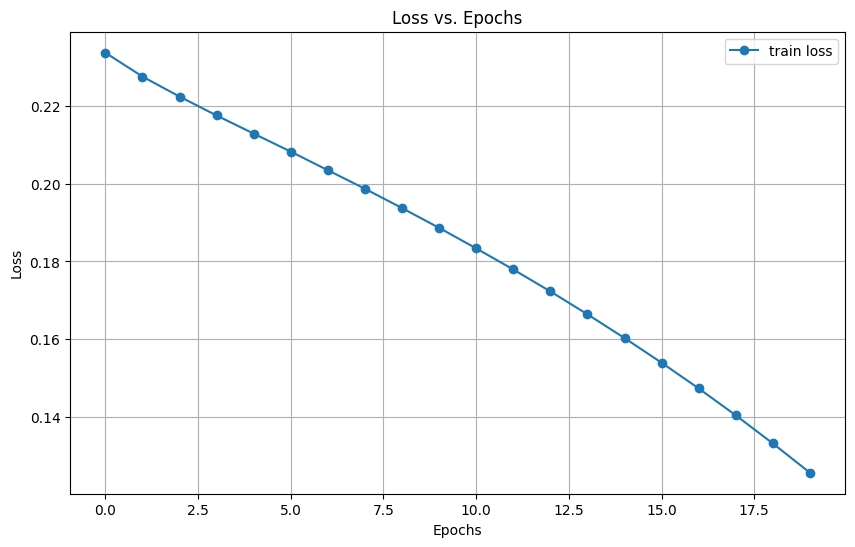

In [11]:
# plot the train and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), train_losses, marker="o", linestyle="-", label="train loss")
# plt.plot(range(EPOCHS), test_accuracies, marker='s', linestyle='--', label='test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 17ms/step
Set MIN/MAX to 7.589389042550465e-06/0.0001635421795072034


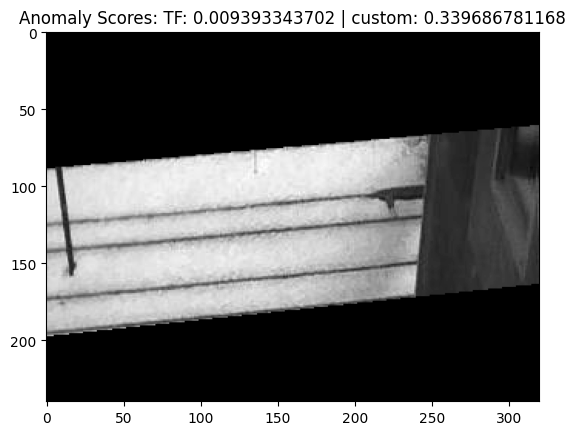

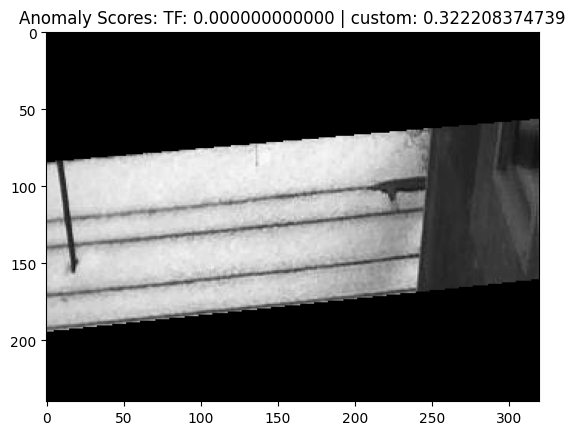

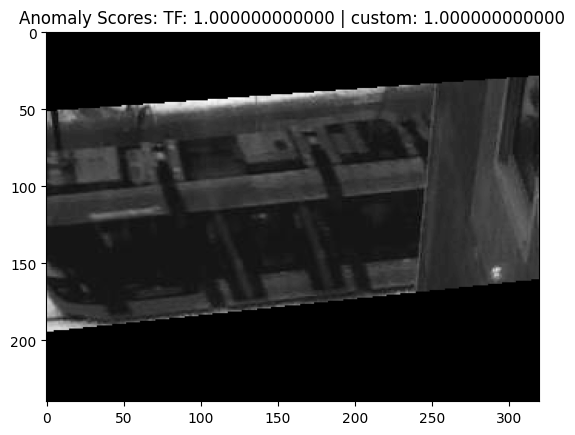

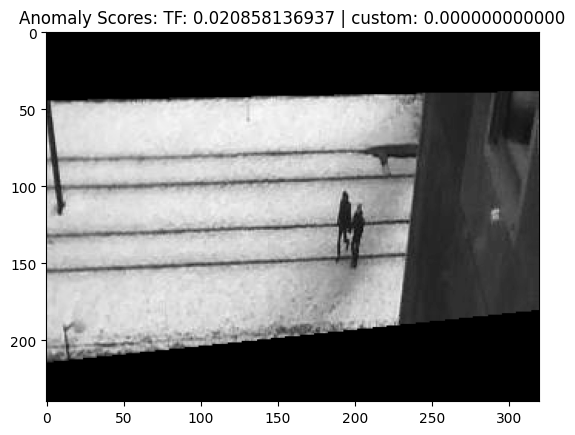

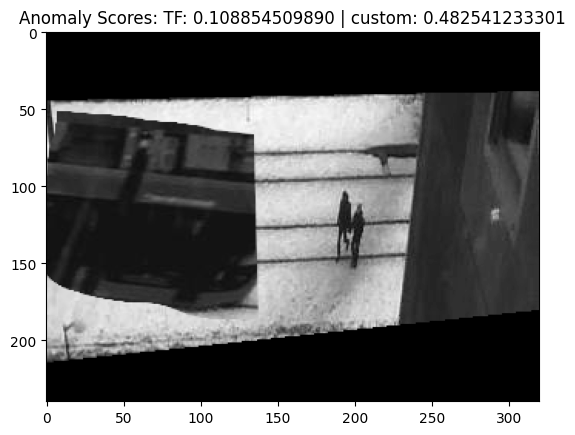

In [15]:
def min_max_normalize(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    return (scores - min_score) / (max_score - min_score)

# Collect TF scores and custom scores for separate normalization
tf_scores = []
custom_scores = []
for x, y in test_ds:
    pred = predict(neural_net, np.array(x))
    score = np.mean(tf.square(y - pred))
    custom_scores.append(score)

    if TRAIN_TF_MODEL:
        tf_pred = tf_neural_net.predict(x)
        tf_score = tf.reduce_mean(tf.math.square(y - tf_pred))
        tf_scores.append(tf_score.numpy())  # Convert to numpy if it's a tensor
    else:
        tf_scores.append(0.0)

# Normalize the scores separately
normalized_tf_scores = min_max_normalize(np.array(tf_scores))
normalized_custom_scores = min_max_normalize(np.array(custom_scores))
print(f"Set MIN/MAX to {np.min(tf_scores)}/{np.max(tf_scores)}")

# Now iterate and plot with normalized scores
for ix, (x, y) in enumerate(test_ds):
    normalized_tf_score = normalized_tf_scores[ix]
    normalized_custom_score = normalized_custom_scores[ix]

    plt.figure()
    plt.set_cmap(plt.colormaps["gray"])
    plt.imshow(test_data.get_image(ix, apply_mask=True))
    plt.title(f"Anomaly Scores: TF: {normalized_tf_score:.12f} | custom: {normalized_custom_score:.12f}")
    plt.show()